## Imports


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import datasets,transforms
from torchvision.utils import make_grid 

In [2]:
# Set device to GPU if available, otherwise CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for windows with CUDA support
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # for macos with MPS support
print(device)

mps


# Data Pre-Processing

## Loading the Dataset with Data augmentation






In [3]:
data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(data, batch_size=60000)
images, labels = next(iter(loader))
data_mean = images.mean()
data_std = images.std()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),  # Convert (H, W, C) image to (C, H, W) tensor and scale to [0, 1]
    transforms.Normalize((data_mean,), (data_std,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((data_mean,), (data_std,))
])

train_data = datasets.MNIST('./data',train=True,download=True,transform=transform_train)
valid_data = datasets.MNIST('./data', train=True, download=True, transform=transform_test)
test_data = datasets.MNIST('./data',train=False,download=True,transform=transform_test)

## Visualizing the Dataset

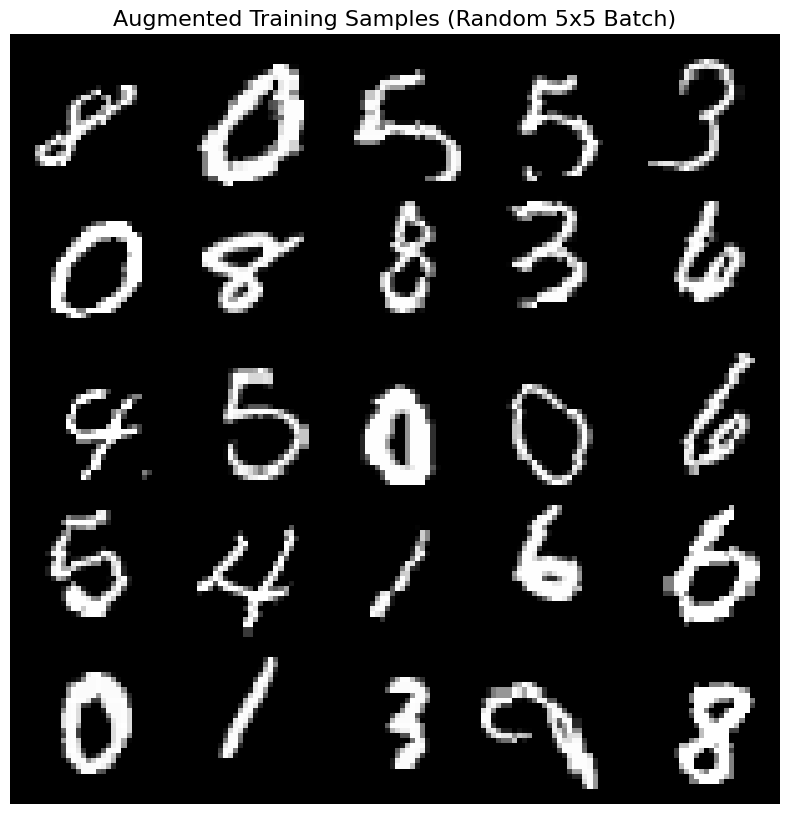

In [5]:
def visualize_batch(dataset):
    loader = DataLoader(dataset, batch_size=25, shuffle=True)
    images, labels = next(iter(loader))
    
    plt.figure(figsize=(10, 10))

    images = (images * data_std) + data_mean   # Denormalize
    grid_img = make_grid(images, nrow=5, padding=2)
    

    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')   # Transpose dimensions: PyTorch (C,H,W) -> Matplotlib (H,W,C)
    plt.axis('off')
    plt.title("Augmented Training Samples (Random 5x5 Batch)", fontsize=16)
    plt.show()

visualize_batch(train_data)

## DataLoader setup

In [6]:
# Change the settings as per the available hardware
batch_size = 256
num_workers = 4
pin_memory = False
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True,
    drop_last=True
)

valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True
)

test_loader = DataLoader(
    test_data, 
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [7]:
len(train_loader),len(valid_loader),len(test_loader)

(187, 47, 40)

# Model Architecture

## Defining the model
Standard formulas used to calculate output shapes: (for convolution & pooling layers)
```
Output = floor((Input + 2×Padding - Kernel) / Stride) + 1

```



In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Dropout2d(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.35),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

## Training and Validation Setup

In [ ]:
def trainCNN(model, train_loader, valid_loader):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    epochs = 30
    patience = 5
    patience_counter = 0
    valid_loss_min = np.inf

    for epoch in range(epochs):
        epoch_start = time.time()
        
        # ===================
        # TRAINING PHASE
        # ===================
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            output = model(images)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            
            # Metrics
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # ===================
        # VALIDATION PHASE
        # ===================
        model.eval()
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        
        with torch.inference_mode():
            for images, labels in valid_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                output = model(images)
                loss = loss_function(output, labels)
                
                valid_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        # ===================
        # STATS & LOGGING
        # ===================
        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(valid_loader)
        avg_train_acc = 100 * train_correct / train_total
        avg_valid_acc = 100 * valid_correct / valid_total
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['valid_loss'].append(avg_valid_loss)
        history['train_acc'].append(avg_train_acc)
        history['valid_acc'].append(avg_valid_acc)

        epoch_time = time.time() - epoch_start
        
        print(f"Epoch [{epoch+1}/{epochs}] | Time: {epoch_time:.1f}s")
        print(f"   Train -> Loss: {avg_train_loss:.4f} | Acc: {avg_train_acc:.2f}%")
        print(f"   Valid -> Loss: {avg_valid_loss:.4f} | Acc: {avg_valid_acc:.2f}%")

        # ===================
        # EARLY STOPPING
        # ===================
        if avg_valid_loss <= valid_loss_min:
            print(f"   Validation loss decreased ({valid_loss_min:.4f} --> {avg_valid_loss:.4f}). Saving model...")
            torch.save(model.state_dict(), 'CNN_best_model.pth')
            valid_loss_min = avg_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"    No improvement. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("\n  Early stopping triggered to prevent overfitting.")
                break
        
        scheduler.step()
        print("-" * 60)

    return history


### Plotting Training and Validation Losses

In [10]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # --- Plot 1: Loss Curves ---
    ax1.plot(history['train_loss'], label='Training Loss', color='blue', linewidth=2)
    ax1.plot(history['valid_loss'], label='Validation Loss', color='orange', linewidth=2, linestyle='--')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Plot 2: Accuracy Curves ---
    ax2.plot(history['train_acc'], label='Training Acc', color='green', linewidth=2)
    ax2.plot(history['valid_acc'], label='Validation Acc', color='red', linewidth=2, linestyle='--')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## Testing Setup

In [11]:
def testCNN(model, loader, device, data_mean, data_std):
    model.eval()
    loss_function = nn.CrossEntropyLoss()
    
    total_loss = 0
    correct_count = 0
    total_count = 0
    all_preds = []
    all_labels = []
    mistakes = []
    
    with torch.inference_mode():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            
            # Predictions
            _, preds = torch.max(outputs, 1)
            
            # Metrics
            total_count += labels.size(0)
            correct_count += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Catch Mistakes (Vectorized search)
            # We find indices where prediction != label
            wrong_indices = (preds != labels).nonzero(as_tuple=True)[0]
            for idx in wrong_indices:
                if len(mistakes) < 20:
                    img = images[idx].cpu() * data_std + data_mean
                    mistakes.append({
                        'img': img,
                        'pred': preds[idx].item(),
                        'true': labels[idx].item()
                    })

    # --- 1. PRINT METRICS ---
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct_count / total_count
    
    print(f"\n{'='*40}")
    print(f"   FINAL RESULTS: {type(model).__name__}")
    print(f"{'='*40}")
    print(f"Avg Loss:      {avg_loss:.4f}")
    print(f"Accuracy:      {accuracy:.2f}% ({correct_count}/{total_count})")
    print(f"{'='*40}\n")
    
    # --- 2. CONFUSION MATRIX ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # --- 3. VISUALIZE MISTAKES ---
    if len(mistakes) > 0:
        print(f"\n Visualizing Top {len(mistakes)} Failures:")
        visualize_failures(mistakes)
    else:
        print("\n Zero mistakes found in the test set.")

def visualize_failures(mistakes):
    rows = int(len(mistakes) / 5) + 1
    plt.figure(figsize=(15, 3.5 * rows))
    
    for i, err in enumerate(mistakes):
        ax = plt.subplot(rows, 5, i + 1)
        plt.imshow(err['img'].permute(1, 2, 0).clip(0, 1), cmap='gray')
        ax.set_title(f"True: {err['true']} | Pred: {err['pred']}", color='red', fontsize=12, fontweight='bold')
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Executing Pipeline

No model found at 'CNN_best_model.pth'
Starting fresh training...
Epoch [1/30] | Time: 8.6s
   Train -> Loss: 0.7656 | Acc: 91.49%
   Valid -> Loss: 0.5748 | Acc: 98.73%
   Validation loss decreased (inf --> 0.5748). Saving model...
------------------------------------------------------------
Epoch [2/30] | Time: 5.5s
   Train -> Loss: 0.6083 | Acc: 97.56%
   Valid -> Loss: 0.5537 | Acc: 99.08%
   Validation loss decreased (0.5748 --> 0.5537). Saving model...
------------------------------------------------------------
Epoch [3/30] | Time: 5.5s
   Train -> Loss: 0.5870 | Acc: 98.21%
   Valid -> Loss: 0.5448 | Acc: 99.25%
   Validation loss decreased (0.5537 --> 0.5448). Saving model...
------------------------------------------------------------
Epoch [4/30] | Time: 5.5s
   Train -> Loss: 0.5754 | Acc: 98.53%
   Valid -> Loss: 0.5451 | Acc: 99.36%
    No improvement. Patience: 1/5
------------------------------------------------------------
Epoch [5/30] | Time: 5.5s
   Train -> Loss: 0

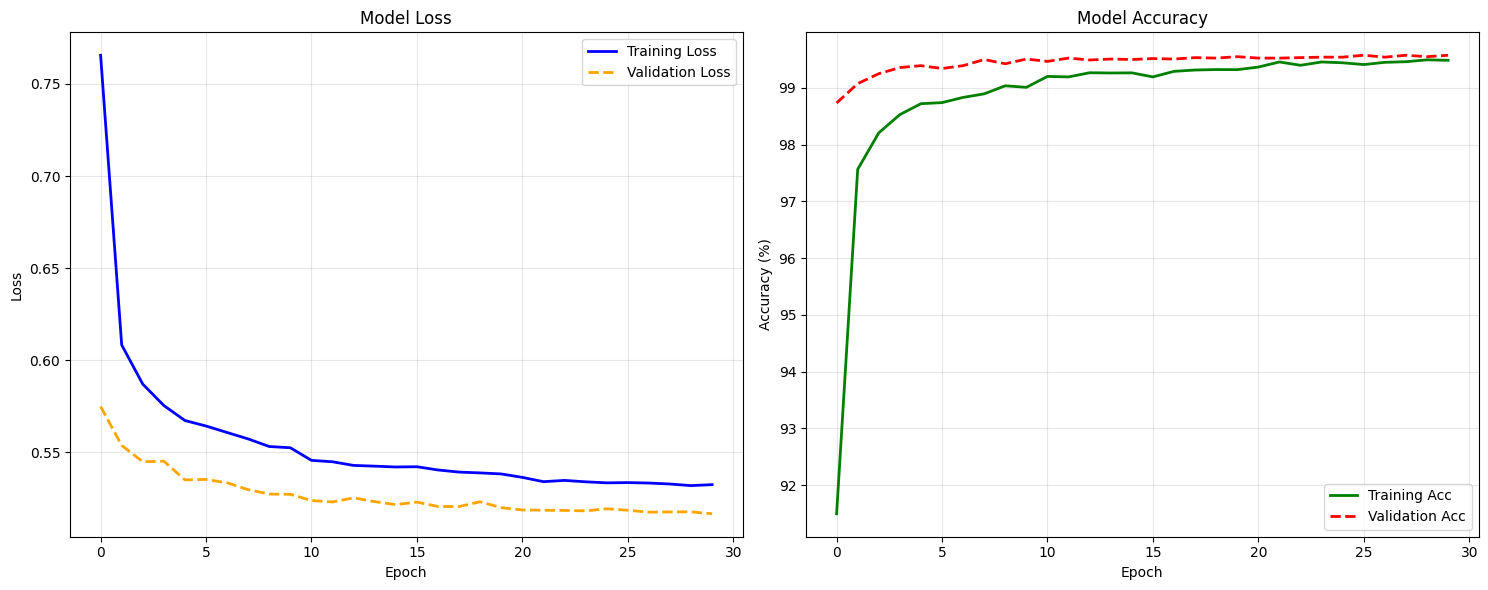


Running Final Evaluation...

   FINAL RESULTS: CNN
Avg Loss:      0.0884
Accuracy:      99.70% (9970/10000)



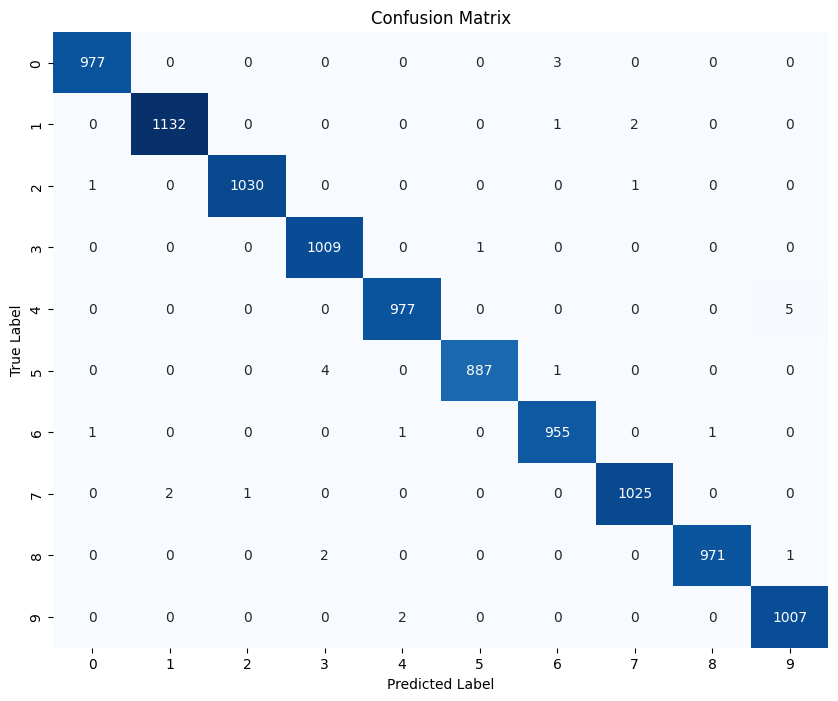


 Visualizing Top 20 Failures:


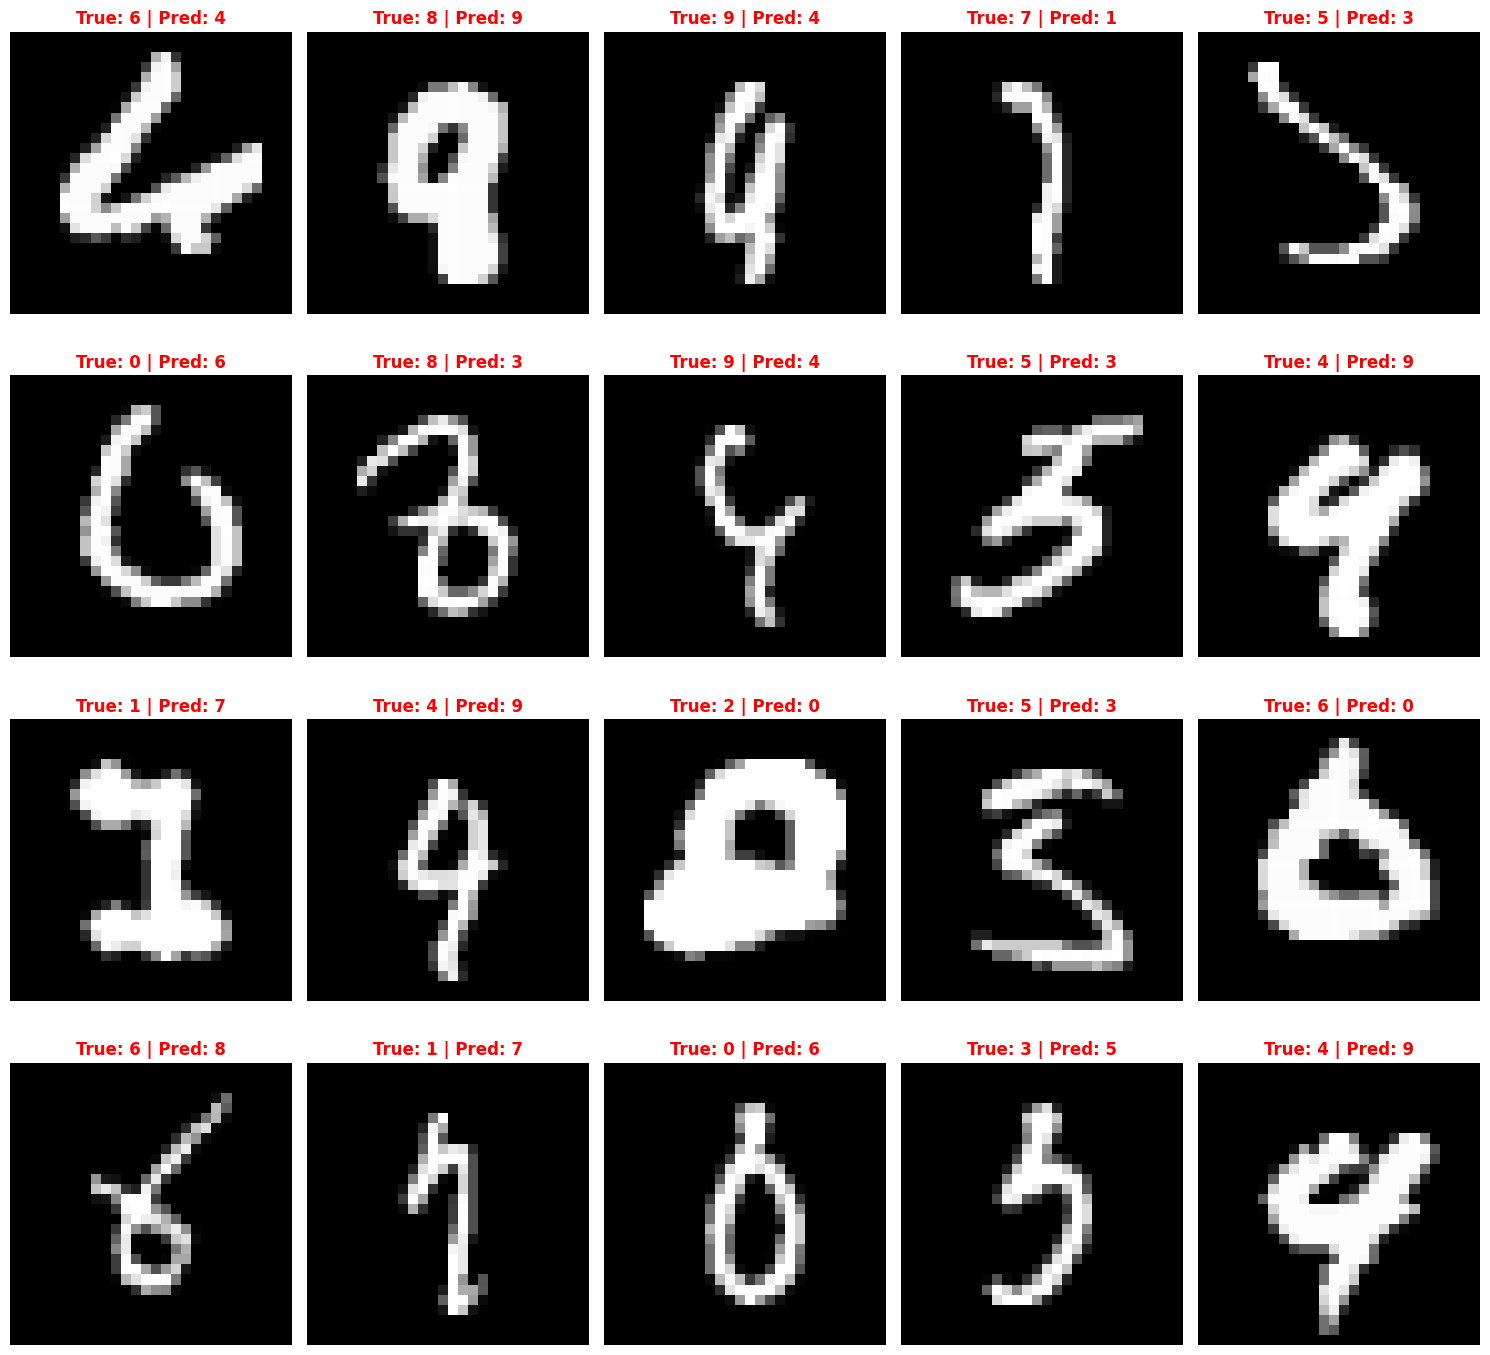

In [12]:
def run_pipeline(model, train_loader, valid_loader, test_loader, device):
    filename = 'CNN_best_model.pth'
    
    # 1. Check if model exists if not train from scratch:
    if os.path.exists(filename):
        print(f"Found existing model: '{filename}'")
        print("Loading weights and skipping training...")
        
        # Load weights (map_location ensures CPU/GPU compatibility)
        model.load_state_dict(torch.load(filename, map_location=device))
        
    else:
        print(f"No model found at '{filename}'")
        print("Starting fresh training...")
        
        # Train the model (this saves the file automatically when done)
        history = trainCNN(model, train_loader, valid_loader)
        plot_training_history(history)

    # 2. Run the Test Setup:
    print("\nRunning Final Evaluation...")
    testCNN(model, test_loader, device, data_mean, data_std)


cnn_model = CNN().to(device)
run_pipeline(cnn_model, train_loader, valid_loader, test_loader, device)